## FS, BE, SS 

In [13]:
from sklearn import datasets
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import warnings 
warnings.filterwarnings(action='ignore')

# 데이터 전처리

data = pd.read_csv('./ToyotaCorolla.csv')

X = data.drop(columns = {'Price','Id', 'Model'})
y = data['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1225)

X_train =pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)


In [14]:
# 특징 추출하지 않고 모든 특징을 사용하여 OLS로 회귀 분석 진행한 결과

X_train = sm.add_constant(X_train)

model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     334.5
Date:                Thu, 13 Oct 2022   Prob (F-statistic):               0.00
Time:                        15:36:27   Log-Likelihood:                -9670.8
No. Observations:                1148   AIC:                         1.941e+04
Df Residuals:                    1114   BIC:                         1.958e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Age_08_04         -119.2473      3.851    -30.962      0.000    -126.804    -111.691
Mfg_Month          -94.5803     10.177     -9.293      0.000    -114.549     -74.612
Mfg_Year             1.6491      0.827      1.994      0.046       0.026       3.272
KM                  -0.0160      0.001    -12.512      0.000      -0.018      -0.013
HP                  20.0920      3.488      5.761      0.000      13.249      26.935
Met_Color          -22.3537     75.446     -0.296      0.767    -170.387     125.679
Automatic          405.6863    151.562      2.677      0.008     108.307     703.066
cc                  -0.1051      0.079     -1.335      0.182      -0.260       0.049
Doors               73.3235     39.949      1.835      0.067      -5.061     151.708
Cylinders           -0.0323      0.002    -14.653      0.000      -0.037      -0.028
Gears               89.1038    206.647      0.431      0.666    -316.356     494.564
Quarterly_Tax       15.9789      1.883      8.485      0.000      12.284      19.674
Weight               9.3413      1.210      7.723      0.000       6.968      11.714
Mfr_Guarantee      255.8755     73.943      3.460      0.001     110.791     400.960
BOVAG_Guarantee    512.7376    128.078      4.003      0.000     261.437     764.039
Guarantee_Period    60.0717     13.034      4.609      0.000      34.499      85.645
ABS               -200.3080    128.349     -1.561      0.119    -452.141      51.525
Airbag_1           117.3204    252.262      0.465      0.642    -377.642     612.283
Airbag_2          -130.0853    130.022     -1.000      0.317    -385.201     125.030
Airco              188.2203     90.807      2.073      0.038      10.049     366.392
Automatic_airco   2534.2770    187.956     13.483      0.000    2165.489    2903.065
Boardcomputer     -294.0145    118.487     -2.481      0.013    -526.497     -61.532
CD_Player          283.7655    100.473      2.824      0.005      86.628     480.903
Central_Lock       -57.5122    147.206     -0.391      0.696    -346.345     231.320
Powered_Windows    361.4448    148.659      2.431      0.015      69.761     653.128
Power_Steering    -160.5441    275.425     -0.583      0.560    -700.954     379.866
Radio              752.0252    811.985      0.926      0.355    -841.167    2345.218
Mistlamps          -20.7270    109.052     -0.190      0.849    -234.698     193.244
Sport_Model        342.0585     89.268      3.832      0.000     166.906     517.210
Backseat_Divider  -269.9782    128.015     -2.109      0.035    -521.156     -18.800
Metallic_Rim       190.0604     94.313      2.015      0.044       5.009     375.112
Radio_cassette    -860.5286    813.223     -1.058      0.290   -2456.150     735.092
Tow_Bar           -164.7947     79.402     -2.075      0.038    -320.589      -9.001
Fuel_Type_CNG    -1024.

In [20]:
def forward_selection(X,y):
   
    variables = X 
    y = y
  
    forward_variables = []
    sv_per_step = [] 
    adj_r_squared_list = []
    steps = []
    
    sl_enter = 0.05
    sl_remove = 0.05
    step = 0

    while len(variables) > 0:
        remainder = list(set(variables) - set(forward_variables))
        pval = pd.Series(index=remainder)
        
        for col in remainder: 
            X_train = X[forward_variables+[col]]
            X_train = sm.add_constant(X_train)
            model = sm.OLS(y,X_train).fit(disp=0)
            pval[col] = model.pvalues[col]
    
        min_pval = pval.min()
        if min_pval < sl_enter: 
            forward_variables.append(pval.idxmin())            
            step += 1
            steps.append(step)
            adj_r_squared = sm.OLS(y,sm.add_constant(X[forward_variables])).fit(disp=0).rsquared_adj
            adj_r_squared_list.append(adj_r_squared)
            sv_per_step.append(forward_variables.copy())
        else:
            break
    return forward_variables, steps, adj_r_squared_list, sv_per_step

In [16]:
def backward_elimination(X, y, threshold_out = 0.05):
    
    feature_list = X.columns.tolist()
    backward_feature = feature_list 
    variable_per_step = [] 
    adj_r_squared_list = []
    steps = []
    step = 0
    
    while True:
        changed=False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[feature_list]))).fit(disp=0)
        pvalues = model.pvalues.iloc[1:] 
        worst_pval = pvalues.max()	
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            backward_feature.remove(worst_feature)
        
        step += 1
        steps.append(step)        
        adj_r_squared = sm.OLS(y, sm.add_constant(pd.DataFrame(X[feature_list]))).fit(disp=0).rsquared_adj
        adj_r_squared_list.append(adj_r_squared)
        variable_per_step.append(backward_feature.copy())
        
        if not changed:
            break
      
    return backward_feature,steps,adj_r_squared_list,variable_per_step

In [18]:
import matplotlib.pyplot as plt

def step_plot(steps, sv_per_step, adj_r_squared):
    fig = plt.figure(figsize=(10,10))
    fig.set_facecolor('white')
    
    font_size = 15
    plt.xticks(steps,[f'step {s}: {len(sv_per_step[i])}' for i,s in enumerate(steps)], fontsize=5)
    plt.plot(steps, adj_r_squared, marker='o')
        
    plt.ylabel('adj_r_squared',fontsize=font_size)
    plt.grid(True)
    plt.show()

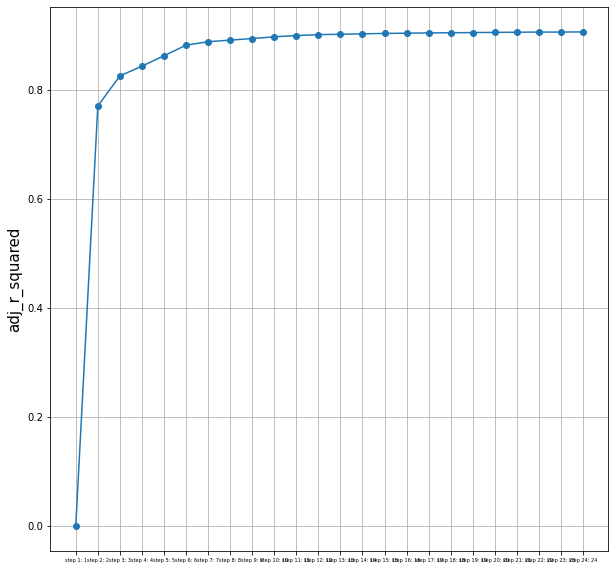

In [21]:
selected_var, step, adj, per_steps = forward_selection(X_train,y_train)
step_plot(step,per_steps,adj)

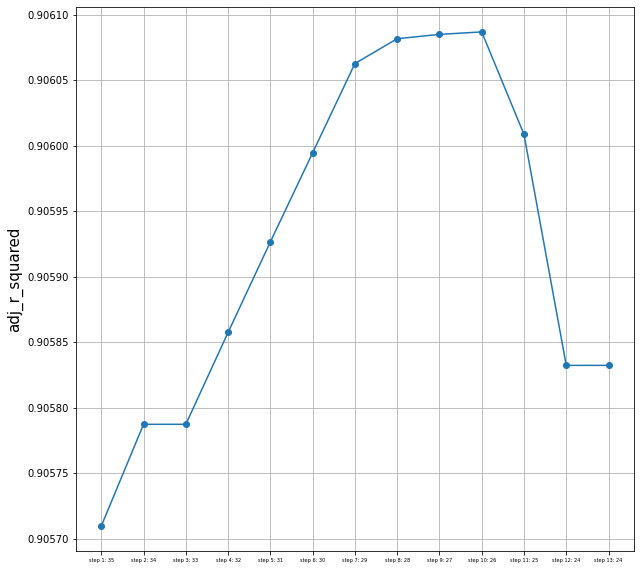

In [ ]:
adjselected_var, step, adj, per_steps = backward_elimination(X_train,y_train)
step_plot(step,per_steps,adj)